# Redes Neurais - Projeto de Análise de Crédito

Alunos: Jonathan Kilner, Luiz Antônio e Matheus Leon

In [1]:
%pip install optuna
%pip install imbalanced-learn
%pip install xgboost
%pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import optuna
import gc
import imblearn
import xgboost as xgb
import scikitplot as skplt

# Leitura dos dados

In [3]:
data_path = './TRNcod.xls'

In [4]:
df = pd.read_csv(data_path, sep='\t', encoding='utf-8')

In [5]:
df.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135098,1,...,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504,1,...,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281910,0,...,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225741,0,...,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403,0,...,1,1,1,0,0,1,0,1,1,0


In [6]:
df.describe()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
count,389196.00000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,3.891960e+05,389196.000000,...,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000
mean,194597.50000,0.889274,0.691952,0.476552,0.296195,0.241179,0.218011,0.186836,4.552049e-01,0.521514,...,0.423378,0.417540,0.425708,0.459820,0.440842,0.436896,0.433709,0.440339,0.655449,0.344551
std,112351.35202,0.313793,0.461687,0.499451,0.456579,0.427799,0.412895,0.389781,2.537459e-01,0.499538,...,0.494095,0.493154,0.494451,0.498384,0.496489,0.496002,0.495587,0.496428,0.475222,0.475222
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.506237e-16,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,97298.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.507866e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,194597.50000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.375241e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,291896.25000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.578835e-01,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,389195.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.drop(['INDEX'], axis=1, inplace=True)

#### Combinando classes em uma única coluna

In [8]:
def label_class (row):
   if row['IND_BOM_1_1'] == 1 and row['IND_BOM_1_2'] == 1:
      return 2
   if row['IND_BOM_1_1'] == 1:
      return 0
   if row['IND_BOM_1_2'] == 1:
      return 1
   return 3

In [9]:
df['class'] = df.apply (lambda row: label_class(row), axis=1)

In [10]:
df.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,1,1,0,1,1,1,0,1,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,1,0,1,1,0,0,0,1,0,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,0,0,0,0,1,0,1,0,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,0,1,1,0,1,0,1,0,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,0,0,1,0,1,1,0,0


In [11]:
print('classe 0:', len(df[df['class'] == 0]))
print('classe 1:', len(df[df['class'] == 1]))
print('classe desconhecida:', len(df[df['class'] > 1]))

classe 0: 255098
classe 1: 134098
classe desconhecida: 0


# Particionamento dos dados

### Particionamento dos dados - 1ª Etapa

In [12]:
class_0 = df[df['class'] == 0]
class_1 = df[df['class'] == 1]

In [13]:
class_0.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,1,0,1,1,0,0,0,1,0,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,0,0,0,0,1,0,1,0,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,0,1,1,0,1,0,1,0,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,0,0,1,0,1,1,0,0
5,0,1,1,0,0,0,1,0.219323,0,0.111111,...,1,1,0,1,0,0,1,1,0,0


In [14]:
class_1.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,1,1,0,1,1,1,0,1,1
10,1,0,1,1,0,0,0,0.654703,0,0.111111,...,1,0,1,0,0,0,0,0,1,1
11,1,1,1,0,0,0,0,0.097444,1,0.111111,...,1,0,1,0,1,0,1,0,1,1
12,1,0,1,0,1,0,0,0.398961,0,0.111111,...,1,1,0,1,0,0,0,0,1,1
17,1,1,1,0,0,0,0,0.142254,0,0.111111,...,0,0,1,0,1,0,1,0,1,1


### Particionamento dos dados - 2ª Etapa

Os dados foram divididos aleatoriamente usando o método train_test_split()
- 50% dos dados para treinamento
- Dos 50% restantes, metade(25% do total) pra validação e o restante(25%) para teste

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train_class_0, X_rem_class_0 = train_test_split(class_0, train_size=0.5)
X_valid_class_0, X_test_class_0 = train_test_split(X_rem_class_0, test_size=0.5)

In [17]:
X_train_class_1, X_rem_class_1 = train_test_split(class_1, train_size=0.5)
X_valid_class_1, X_test_class_1 = train_test_split(X_rem_class_1, test_size=0.5)

Concatenamos os dados das duas classes para todos os conjuntos.

In [18]:
X_train = pd.concat([X_train_class_0, X_train_class_1])

In [19]:
X_train.shape

(194598, 246)

Porém os dados estão ordenados, com a classe 0 no início e a classe 1 ao final. 

Precisamos então fazer um shuffle nos dados de todos os conjuntos.

In [20]:
X_train

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
115563,1,1,1,0,0,0,0,7.357476e-01,1,0.111111,...,1,0,1,1,1,0,0,1,0,0
280523,1,0,1,0,0,1,0,3.965191e-01,1,0.111111,...,0,0,0,0,1,0,0,1,0,0
387366,1,1,0,0,0,0,1,3.972574e-01,1,0.111111,...,1,0,1,1,0,0,1,1,0,0
321933,1,1,1,0,0,0,0,8.987454e-01,0,0.111111,...,1,0,1,0,1,0,1,1,0,0
156096,1,1,1,0,0,0,0,2.698125e-01,1,0.111111,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245050,1,0,1,1,0,0,0,3.864666e-01,0,0.111111,...,0,0,1,1,0,1,1,0,1,1
149463,1,1,0,1,0,0,0,1.614502e-01,1,0.111111,...,0,0,0,0,1,1,1,0,1,1
239343,1,0,1,0,0,0,1,1.115286e-01,0,0.111111,...,0,1,0,1,0,0,0,0,1,1
162476,1,1,0,0,0,1,0,5.506237e-16,0,0.111111,...,0,0,1,0,1,0,1,0,1,1


Para isso, iremos utilizar a função shuffle() do sklearn.utils.

In [21]:
from sklearn.utils import shuffle

In [22]:
X_train = shuffle(X_train, random_state=85)

In [23]:
X_train.shape

(194598, 246)

In [24]:
X_train.reset_index(drop=True, inplace=True)

Abaixo percebemos que os dados foram embaralhados.

In [25]:
X_train

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,1,0,1,0,0,0,0.539355,0,0.666667,...,1,1,0,1,1,0,1,1,0,0
1,1,1,0,0,0,1,0,0.160825,0,0.111111,...,0,0,0,1,1,1,0,1,0,0
2,1,1,0,0,0,0,1,0.893350,1,0.111111,...,1,1,0,0,0,0,1,0,1,1
3,1,1,1,0,0,0,0,0.736429,1,0.111111,...,0,1,0,1,1,0,0,1,0,0
4,0,1,0,1,0,0,1,0.419123,1,0.111111,...,1,1,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194593,1,1,0,0,0,1,0,0.243801,1,0.111111,...,0,0,1,0,1,0,1,1,0,0
194594,1,1,0,0,0,1,0,0.389704,0,0.222222,...,0,1,1,0,1,1,0,1,0,0
194595,1,1,0,0,0,1,0,0.651523,0,0.111111,...,0,1,0,0,0,0,0,0,1,1
194596,1,1,1,0,0,0,0,0.825141,0,0.111111,...,0,0,0,0,1,1,1,1,0,0


Vamos obter então o valor de y utilizando a coluna "class" do dataset.

In [26]:
y_train = X_train['class'].values

In [27]:
y_train

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

Vamos aplicar os mesmos procedimentos para os dados de validação e teste.

In [28]:
X_valid = pd.concat([X_valid_class_0, X_valid_class_1])
X_valid = shuffle(X_valid, random_state=27)
X_valid.reset_index(drop=True, inplace=True)
y_valid = X_valid['class'].values

In [29]:
X_valid

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,0,0,0,0,1,1,0.484549,1,0.111111,...,0,1,0,0,1,0,1,1,0,0
1,1,0,0,1,1,0,0,0.056723,1,0.111111,...,1,0,0,1,1,1,0,0,1,1
2,1,0,1,0,0,1,0,0.480517,0,0.111111,...,1,0,1,0,0,1,1,0,1,1
3,1,0,0,1,0,0,1,0.210974,1,0.111111,...,0,0,1,1,0,0,0,0,1,1
4,1,1,1,0,0,0,0,0.176444,0,0.111111,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97293,1,0,1,0,1,0,0,0.523680,0,0.111111,...,1,1,0,0,0,0,1,1,0,0
97294,0,1,0,0,1,0,1,0.151454,0,0.111111,...,0,1,1,1,1,0,0,0,1,1
97295,0,1,1,0,1,0,0,0.477620,1,0.111111,...,0,1,1,0,1,0,1,1,0,0
97296,1,1,0,0,0,0,1,0.533392,0,0.111111,...,1,0,0,1,0,0,0,1,0,0


In [30]:
y_valid

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [31]:
X_test = pd.concat([X_test_class_0, X_test_class_1])
X_test = shuffle(X_test, random_state=13)
X_test.reset_index(drop=True, inplace=True)
y_test = X_test['class'].values

In [32]:
X_test

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,0,1,0,0,1,0,1,0.203307,1,0.111111,...,1,1,1,0,0,0,1,0,1,1
1,0,1,0,1,0,1,0,0.463081,0,0.111111,...,0,0,0,1,1,0,0,1,0,0
2,1,0,1,1,0,0,0,0.700820,1,0.111111,...,0,1,1,1,1,0,1,0,1,1
3,1,1,0,0,0,1,0,0.561164,0,0.111111,...,0,0,0,0,1,1,0,1,0,0
4,1,1,1,0,0,0,0,0.170537,1,0.111111,...,1,0,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97295,1,1,1,0,0,0,0,0.135495,1,0.111111,...,1,0,0,1,0,0,0,1,0,0
97296,1,0,1,0,0,1,0,0.056609,0,0.111111,...,1,1,0,0,0,0,0,0,1,1
97297,0,1,0,1,0,0,1,0.024918,0,0.111111,...,1,0,1,1,0,0,0,0,1,1
97298,1,1,0,0,1,0,0,0.195129,0,0.111111,...,0,1,1,1,0,1,1,1,0,0


In [33]:
y_test

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [34]:
print('Quantidade de entradas para treino:', len(X_train))
print('Quantidade de entradas para validação:', len(X_valid))
print('Quantidade de entradas para teste:', len(X_test))

Quantidade de entradas para treino: 194598
Quantidade de entradas para validação: 97298
Quantidade de entradas para teste: 97300


### Oversampling - Replicar a classe minoritária para ficar do tamanho da classe majoritária

In [35]:
print('Quantidade antes do over sampling')
print('Quantidade classe 0 treino:', (X_train[X_train['class'] == 0]).shape[0])
print('Quantidade classe 1 treino:', (X_train[X_train['class'] == 1]).shape[0])
print('Quantidade classe 0 validação:', (X_valid[X_valid['class'] == 0]).shape[0])
print('Quantidade classe 1 validação:', (X_valid[X_valid['class'] == 1]).shape[0])
print('Quantidade classe 0 teste:', (X_test[X_test['class'] == 0]).shape[0])
print('Quantidade classe 1 teste:', (X_test[X_test['class'] == 1]).shape[0])

Quantidade antes do over sampling
Quantidade classe 0 treino: 127549
Quantidade classe 1 treino: 67049
Quantidade classe 0 validação: 63774
Quantidade classe 1 validação: 33524
Quantidade classe 0 teste: 63775
Quantidade classe 1 teste: 33525


In [36]:
from imblearn.over_sampling import SMOTE

Vamos utilizar a biblioteca imblearn para fazer o oversampling.

Para isso usamos a função SMOTE (Synthetic Minority Over-sampling Technique) que cria por padrão novos dados sintéticos para a classe minoritária.

In [37]:
oversample = SMOTE(n_jobs=-1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [38]:
print('Quantidade classe 0 treino:', (X_train[X_train['class'] == 0]).shape[0])
print('Quantidade classe 1 treino:', (X_train[X_train['class'] == 1]).shape[0])

Quantidade classe 0 treino: 127549
Quantidade classe 1 treino: 127549


Como não sabemos se os dados estão embaralhados após o oversample, vamos embaralhar novamente.

In [39]:
X_train = shuffle(X_train, random_state=42)
X_train.reset_index(drop=True, inplace=True)

In [40]:
X_train

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,1,1,0,0,0,0,0.140550,1,0.111111,...,1,1,0,0,0,0,0,1,0,0
1,1,1,0,0,0,0,1,0.243744,1,0.111111,...,1,1,1,0,0,0,0,0,1,1
2,1,0,1,0,0,0,1,0.641186,0,0.111111,...,1,1,1,0,0,0,1,1,0,0
3,1,0,0,0,1,0,1,0.657486,0,0.111111,...,0,0,0,0,0,1,0,1,0,0
4,1,0,1,0,0,0,1,0.189449,0,0.111111,...,1,0,0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255093,1,1,0,1,0,0,0,0.208078,0,0.111111,...,0,1,1,0,0,1,0,0,1,1
255094,1,1,1,0,0,0,0,0.479495,0,0.111111,...,0,0,1,1,0,1,0,0,1,1
255095,1,1,0,1,0,0,0,0.202796,0,0.111111,...,0,1,1,1,0,0,0,1,0,0
255096,1,1,1,0,0,0,0,0.797085,0,0.111111,...,0,0,1,1,1,0,1,0,1,1


Ao embaralhar os dados de X, perdemos a referência de y, como ainda temos a coluna "class" presente, vamos utilizar ela para obter o valor de y.

In [41]:
y_train = X_train['class'].values

In [42]:
X_train.drop(['class', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1, inplace=True)

Vamos aplicar o mesmo para o conjunto de validação.

In [43]:
oversample = SMOTE(n_jobs=-1)
X_valid, y_valid = oversample.fit_resample(X_valid, y_valid)

In [44]:
X_valid = shuffle(X_valid, random_state=15)
X_valid.reset_index(drop=True, inplace=True)
y_valid = X_valid['class'].values
X_valid.drop(['class', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1, inplace=True)

In [45]:
print('Quantidade classe 0 valid:', (y_valid == 0).sum())
print('Quantidade classe 1 valid:', (y_valid == 1).sum())

Quantidade classe 0 valid: 63774
Quantidade classe 1 valid: 63774


O Conjunto de teste não necessita de replicação, então vamos apenas dropar as colunas que não serão utilizadas.

In [46]:
X_test.drop(['class', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1, inplace=True)

In [47]:
X_test

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14
0,0,1,0,0,1,0,1,0.203307,1,0.111111,...,0,0,0,1,1,1,0,0,0,1
1,0,1,0,1,0,1,0,0.463081,0,0.111111,...,0,0,1,0,0,0,1,1,0,0
2,1,0,1,1,0,0,0,0.700820,1,0.111111,...,1,0,0,0,1,1,1,1,0,1
3,1,1,0,0,0,1,0,0.561164,0,0.111111,...,0,0,1,0,0,0,0,1,1,0
4,1,1,1,0,0,0,0,0.170537,1,0.111111,...,0,1,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97295,1,1,1,0,0,0,0,0.135495,1,0.111111,...,1,1,1,1,0,0,1,0,0,0
97296,1,0,1,0,0,1,0,0.056609,0,0.111111,...,1,0,1,1,1,0,0,0,0,0
97297,0,1,0,1,0,0,1,0.024918,0,0.111111,...,0,1,0,1,0,1,1,0,0,0
97298,1,1,0,0,1,0,0,0.195129,0,0.111111,...,0,0,0,0,1,1,1,0,1,1


In [48]:
y_test

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [49]:
print('Quantidade classe 0 test:', (y_test == 0).sum())
print('Quantidade classe 1 test:', (y_test == 1).sum())

Quantidade classe 0 test: 63775
Quantidade classe 1 test: 33525


# Funções auxiliares para métricas

Métricas utilizadas:

- Teste estatístico Kolmogorov-Smirnov (KS)

- Acurácia

- Recall

- Precision

- F1-Score

- Auroc (Área sob a Curva Roc)

- Matriz de confusão
      [TP  FP]
      [FN  TN]

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, RocCurveDisplay

from scipy.stats import ks_2samp

import matplotlib
import matplotlib.pyplot as plt

In [51]:
def plot_ks_statistic(y, y_pred_scores=None):
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()

In [52]:
def plot_roc_curve(actual, pred_proba):
    skplt.metrics.plot_roc(actual, pred_proba)
    plt.show()

In [53]:
def print_metrics(actual, pred, pred_proba):
    print('Accuracy: {:.4f}'.format(accuracy_score(actual, pred)))
    print('Recall: {:.4f}'.format(recall_score(actual, pred)))
    print('Precision: {:.4f}'.format(precision_score(actual, pred)))
    print('F1-Score: {:.4f}'.format(f1_score(actual, pred)))
    print('ROC AUC Score: {:.4f}'.format(roc_auc_score(actual, pred_proba[:, 1])))
    print('Matriz de confusão no conjunto de teste:')
    print(confusion_matrix(actual, pred))
    plot_ks_statistic(actual, pred_proba)
    plot_roc_curve(actual, pred_proba)

In [54]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    recall = recall_score(actual, pred)
    precision = precision_score(actual, pred)
    f1 = f1_score(actual, pred)
    return accuracy, recall, precision, f1

In [55]:
def eval_ks_metric(actual, pred):
    df = pd.DataFrame()
    df['real'] = actual
    df['proba'] = pred[:, 1]
    
    # Recover each class
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    ks_stat = ks_2samp(class0['proba'], class1['proba'])
    return ks_stat.statistic

# Algoritmos

In [56]:
n_trials=100

### Modelo MLP

Descrição dos principais parâmetros:

 - hidden_layer_sizes: tupla, comprimento da camada oculta. O padrão é (100,), o que significa uma única camada oculta com 100 neurônios.

 - activation: função de ativação para a camada oculta. Os valores possíveis são ‘identity’, ‘logistic’, ‘tanh’, ‘relu’. O padrão é ‘relu’.

 - learning_rate_init: a taxa de aprendizado inicial para ‘sgd’ ou ‘adam’. O padrão é 0,001.

In [57]:
from sklearn.neural_network import MLPClassifier

#### 1ª Configuração

In [58]:
mlp_clf = MLPClassifier(random_state=67)

In [59]:
%%time
mlp_clf.fit(X_train, y_train)

CPU times: total: 17min 21s
Wall time: 5min 5s


c:\Users\jonat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=67)

In [60]:
y_mlp_pred_valid_1st = mlp_clf.predict(X_valid)
y_mlp_pred_valid_proba_1st = mlp_clf.predict_proba(X_valid)

##### 1ª Análise de desempenho

Accuracy: 0.7196
Recall: 0.6554
Precision: 0.7520
F1-Score: 0.7004
ROC AUC Score: 0.7986
Matriz de confusão no conjunto de teste:
[[49987 13787]
 [21978 41796]]


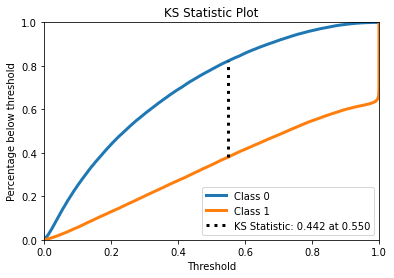

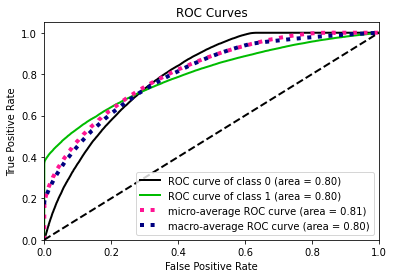

In [61]:
print_metrics(y_valid, y_mlp_pred_valid_1st, y_mlp_pred_valid_proba_1st)

#### 2ª Configuração

Na 2ª configuração, utilizamos a biblioteca optuna para otimizar os parâmetros do modelo. 

Nessa configuração, o modelo foi treinado sempre com duas camadas ocultas, com os neurônios variando de 10 a 100, com passo de 10.

In [62]:
def mlp_fn(trial):
  # Define the search space
    params = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 0.1, step=0.001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 100, step=10),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=10),
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh',  'relu'])
    }

    mlp_reg = MLPClassifier(
        hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons']),
        learning_rate_init=params['learning_rate_init'],
        activation=params['activation'],
        random_state=42
    )

    mlp_reg.fit(X_train, y_train)

    y_pred_valid_proba = mlp_reg.predict_proba(X_valid)

    statistic = eval_ks_metric(y_valid, y_pred_valid_proba)

    gc.collect()

    return statistic

In [63]:
mlp_study = optuna.create_study(direction="maximize")

[I 2022-10-18 08:47:01,349] A new study created in memory with name: no-name-737f6d33-4d5d-491b-8267-6dc182a4596b


In [64]:
mlp_study.optimize(mlp_fn, n_trials=n_trials)

[I 2022-10-18 08:47:44,882] Trial 0 finished with value: 0.44908583435255744 and parameters: {'learning_rate_init': 0.08700000000000001, 'first_layer_neurons': 50, 'second_layer_neurons': 100, 'activation': 'relu'}. Best is trial 0 with value: 0.44908583435255744.
[I 2022-10-18 08:49:46,168] Trial 1 finished with value: 0.45576567253112554 and parameters: {'learning_rate_init': 0.035, 'first_layer_neurons': 30, 'second_layer_neurons': 90, 'activation': 'logistic'}. Best is trial 1 with value: 0.45576567253112554.
[I 2022-10-18 08:50:15,487] Trial 2 finished with value: 0.41297393922288084 and parameters: {'learning_rate_init': 0.096, 'first_layer_neurons': 100, 'second_layer_neurons': 70, 'activation': 'identity'}. Best is trial 1 with value: 0.45576567253112554.
[I 2022-10-18 08:51:42,358] Trial 3 finished with value: 0.45231599084266316 and parameters: {'learning_rate_init': 0.013000000000000001, 'first_layer_neurons': 10, 'second_layer_neurons': 20, 'activation': 'identity'}. Best i

##### 2ª Análise de desempenho

In [ ]:
mlp_study.best_params

{'learning_rate_init': 0.007,
 'first_layer_neurons': 40,
 'second_layer_neurons': 100,
 'activation': 'relu'}

Aqui iremos analisar o desempenho do modelo com os melhores parâmetros encontrados pela biblioteca optuna.

Accuracy: 0.7378
Recall: 0.6326
Precision: 0.8011
F1-Score: 0.7070
ROC AUC Score: 0.8224
Matriz de confusão no conjunto de teste:
[[53758 10016]
 [23428 40346]]


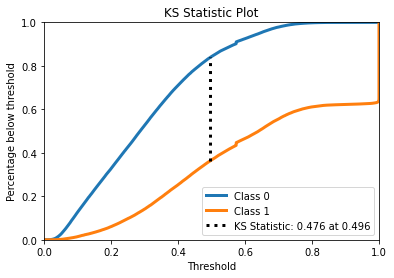

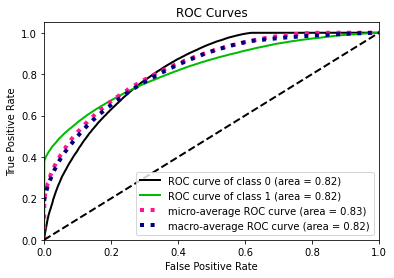

In [ ]:
mlp_reg = MLPClassifier(
    hidden_layer_sizes=(mlp_study.best_params['first_layer_neurons'], mlp_study.best_params['second_layer_neurons']),
    learning_rate_init=mlp_study.best_params['learning_rate_init'],
    activation=mlp_study.best_params['activation'],
    random_state=42
)

mlp_reg.fit(X_train, y_train)

y_pred_valid = mlp_reg.predict(X_valid)
y_pred_valid_proba = mlp_reg.predict_proba(X_valid)

print_metrics(y_valid, y_pred_valid, y_pred_valid_proba)

### Modelo Random Forest

Descrição dos principais parâmetros que serão utilizados:

- n_estimators
  - O número de árvores na floresta.

- max_depth
  - A profundidade máxima da árvore.
  - 'None' significa que os nós são expandidos até que todas as folhas sejam puras(se o nó possui prediz apenas 1 classe) ou até que todas as folhas contenham menos de min_samples_split amostras.

- max_leaf_nodes
  - O número max de nós folha. 
  - 'None' significa então pode haver um número ilimitado de nós folha.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- n_estimators = 100

- criterion = 'gini'

- max_depth = None 

- min_samples_split = 2

- min_samples_leaf = 1

- max_features = 'sqrt'

- max_leaf_nodes = None

In [ ]:
clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
%%time
history_rf = clf_rf.fit(X_train, y_train)

CPU times: total: 5min 54s
Wall time: 34.7 s


In [ ]:
y_valid_pred_rf_1st = clf_rf.predict(X_valid)

In [ ]:
y_valid_proba_rf_1st = clf_rf.predict_proba(X_valid)

##### 1ª Análise de Desempenho

Accuracy: 0.7344
Recall: 0.6493
Precision: 0.7826
F1-Score: 0.7097
ROC AUC Score: 0.8143
Matriz de confusão no conjunto de teste:
[[52269 11505]
 [22366 41408]]


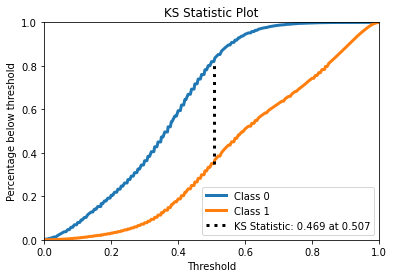

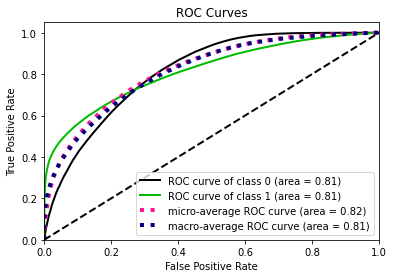

In [ ]:
print_metrics(y_valid, y_valid_pred_rf_1st, y_valid_proba_rf_1st)

#### 2ª Configuração

Para a segunda configuração vamos criar um estudo de caso usando o optuna, variando alguns hiperparâmetros

In [ ]:
def random_forest(trial):
    params = {
        'n_estimators':  trial.suggest_int('n_estimators', 100, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 1000, step = 10)
    }
    # Create the model
    rnd_forest = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_leaf=params["min_samples_leaf"],
        random_state=0,
        n_jobs=-1
    )

    rnd_forest.fit(X_train, y_train)

    y_pred_proba = rnd_forest.predict_proba(X_valid)

    statistic = eval_ks_metric(y_valid, y_pred_proba)

    gc.collect()

    return statistic

In [ ]:
rf_study = optuna.create_study(direction="maximize")

[I 2022-10-16 23:15:12,541] A new study created in memory with name: no-name-b79e8350-d7b2-4f22-8862-82e3014f9c87


In [ ]:
%%time
rf_study.optimize(random_forest, n_trials=n_trials)

[I 2022-10-16 23:15:53,785] Trial 0 finished with value: 0.44370746699281843 and parameters: {'n_estimators': 230, 'max_depth': 45, 'min_samples_leaf': 960}. Best is trial 0 with value: 0.44370746699281843.
[I 2022-10-16 23:16:27,176] Trial 1 finished with value: 0.3918995201806379 and parameters: {'n_estimators': 390, 'max_depth': 4, 'min_samples_leaf': 750}. Best is trial 0 with value: 0.44370746699281843.
[I 2022-10-16 23:17:04,289] Trial 2 finished with value: 0.45971712610154614 and parameters: {'n_estimators': 180, 'max_depth': 31, 'min_samples_leaf': 420}. Best is trial 2 with value: 0.45971712610154614.
[I 2022-10-16 23:17:28,016] Trial 3 finished with value: 0.46994072819644367 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_leaf': 80}. Best is trial 3 with value: 0.46994072819644367.
[I 2022-10-16 23:18:09,939] Trial 4 finished with value: 0.4465769749427667 and parameters: {'n_estimators': 230, 'max_depth': 26, 'min_samples_leaf': 820}. Best is trial 3 wi

CPU times: total: 23h 48min 46s
Wall time: 2h 9min 17s


In [ ]:
rf_study.best_params

{'n_estimators': 310, 'max_depth': 48, 'min_samples_leaf': 10}

##### 2ª Análise de Desempenho

In [ ]:
rnd_forest_trial = RandomForestClassifier(
    n_estimators=rf_study.best_params["n_estimators"],
    max_depth=rf_study.best_params["max_depth"],
    min_samples_leaf=rf_study.best_params["min_samples_leaf"],
    random_state=0,
    n_jobs=-1
)

rnd_forest_trial.fit(X_train, y_train)

RandomForestClassifier(max_depth=48, min_samples_leaf=10, n_estimators=310,
                       n_jobs=-1, random_state=0)

Accuracy: 0.7441
Recall: 0.6690
Precision: 0.7872
F1-Score: 0.7233
ROC AUC Score: 0.8262
Matriz de confusão no conjunto de teste:
[[52240 11534]
 [21111 42663]]


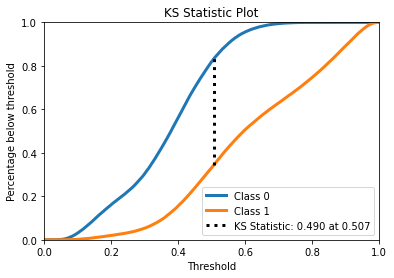

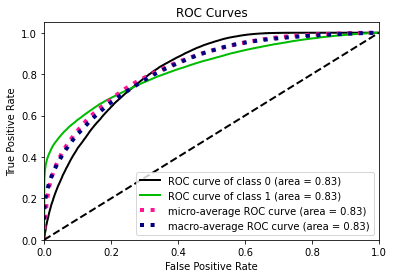

In [ ]:
y_pred_valid = rnd_forest_trial.predict(X_valid)
y_pred_valid_proba = rnd_forest_trial.predict_proba(X_valid)

print_metrics(y_valid, y_pred_valid, y_pred_valid_proba)

### Modelo SVM

Descrição dos principais parâmetros:

- C
  - Parâmetro de regularização. A força da regularização é inversamente proporcional a C. Deve ser estritamente positiva. A penalidade é uma penalidade de 12 ao quadrado.

- kernel
  - Especifica o tipo de kernel a ser usado no algoritmo. Se nenhum for fornecido, 'rbf' será usado. Se um callable for fornecido, ele será usado para pré-computar a matriz do kernel a partir de matrizes de dados; essa matriz deve ser uma matriz de forma
  - Valor default: rbf

- degree
  - Grau da função kernel polinomial ('poli'). Ignorado por todos os outros kernels.
  - Valor default: 3

- gamma
  - Coeficiente de kernel para 'rbf', 'poli' e 'sigmóide'


In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
clf_svm = SVC(gamma='auto', probability=True)

In [ ]:
%%time
clf_svm.fit(X_train, y_train)

CPU times: total: 16h 21min 38s
Wall time: 20h 47min 52s


SVC(gamma='auto', probability=True)

In [ ]:
y_valid_pred_svm = clf_svm.predict(X_valid)

In [ ]:
y_valid_proba_svm = clf_svm.predict_proba(X_valid)

##### Análise de Desempenho

Accuracy: 0.7297
Recall: 0.6423
Precision: 0.7783
F1-Score: 0.7038
ROC AUC Score: 0.8116
Matriz de confusão no conjunto de teste:
[[52108 11666]
 [22810 40964]]


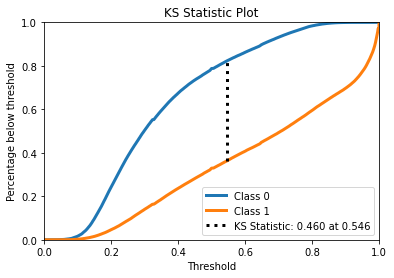

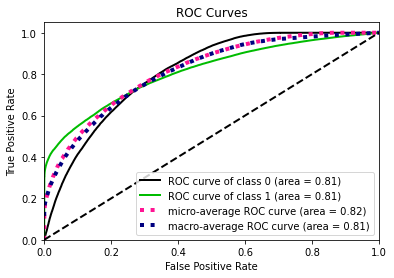

In [ ]:
print_metrics(y_valid, y_valid_pred_svm, y_valid_proba_svm)

### Ensemble de MLP

Para o ensemble de MLP utilizamos a biblioteca BaggingClassifier do Sklearn, que cria um conjunto de classificadores baseados no classficador escolhido, cada um treinado em uma parte do conjunto de dados.

No final, a predição é feita pela agregação de cada das predições de cada classificador, seja essa agregação por votação ou por média.

In [ ]:
from sklearn.ensemble import BaggingClassifier

Para esse ensemble, utilizamos o modelo MLP com as melhores configurações obtidas pelo Optuna.

In [ ]:
params_ens = mlp_study.best_params

ens_mlp = MLPClassifier(
        hidden_layer_sizes=(params_ens['first_layer_neurons'], params_ens['second_layer_neurons']),
        learning_rate_init=params_ens['learning_rate_init'],
        activation=params_ens['activation'],
        random_state=42
    )

Iremos utilizar 100 estimadores para o ensemble.

In [ ]:
mlp_ens_clf = BaggingClassifier(base_estimator=ens_mlp, n_estimators=100, random_state=0, n_jobs=-1)

In [ ]:
mlp_ens_clf.fit(X_train, y_train)

In [ ]:
y_valid_pred_ens_mlp = mlp_ens_clf.predict(X_valid)
y_valid_pred_proba_ens_mlp = mlp_ens_clf.predict_proba(X_valid)

##### Análise de desempenho

Accuracy: 0.7446
Recall: 0.6573
Precision: 0.7964
F1-Score: 0.7202
ROC AUC Score: 0.8295
Matriz de confusão no conjunto de teste:
[[53054 10720]
 [21854 41920]]


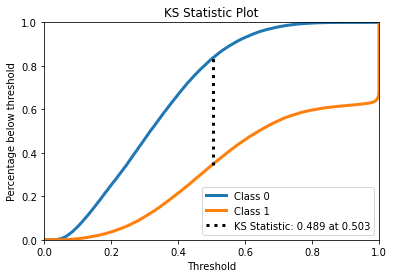

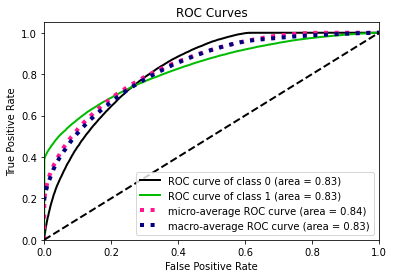

In [ ]:
print_metrics(y_valid, y_valid_pred_ens_mlp, y_valid_pred_proba_ens_mlp)

### Modelo AdaBoost

O modelo AdaBoost é parecido com o modelo do BaggingClassifier, porém, ao invés de treinar vários classificadores, ele treina um classificador e, em seguida, treina outro classificador que tenta corrigir os erros do primeiro classificador.

Definição dos parâmetros
* base_estimator object, default=None
    * O estimador base a partir do qual o conjunto impulsionado é construído. É necessário suporte para ponderação de amostra, bem como atributos classes_ e n_classes_ apropriados. Se Nenhum, então o estimador base é DecisionTreeClassifier inicializado com max_depth=1.

* n_estimators int, default=50
    * O número máximo de estimadores em que o reforço é encerrado. Em caso de ajuste perfeito, o processo de aprendizagem é interrompido precocemente. Os valores devem estar no intervalo [1, inf).

* learning_rate float, default=1.0
    * Peso aplicado a cada classificador em cada iteração de reforço. Uma taxa de aprendizado mais alta aumenta a contribuição de cada classificador. Há um trade-off entre os parâmetros learning_rate e n_estimators. Os valores devem estar no intervalo (0,0, inf).

* algorithm {‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’
    * Se 'SAMME.R', use o algoritmo de reforço real SAMME.R. base_estimator deve suportar o cálculo de probabilidades de classe. Se 'SAMME', use o algoritmo de reforço discreto SAMME. O algoritmo SAMME.R normalmente converge mais rápido que o SAMME, alcançando um erro de teste menor com menos iterações de reforço.

* random_state int, RandomState instance or None, default=None
    * Controla a semente aleatória fornecida em cada base_estimator em cada iteração de reforço. Assim, ele só é usado quando base_estimator expõe um random_state. Passe um int para saída reproduzível em várias chamadas de função. Consulte Glossário.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

#### Configuração Utilizada

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- n_estimators = 100

- learning_rate = 1

- algorithm = SAMME.R

- random_state = 1


In [ ]:
clf_adaBoost = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=0)

In [ ]:
%%time
history_adaBoost = clf_adaBoost.fit(X_train, y_train)

CPU times: total: 4min 4s
Wall time: 4min 41s


In [ ]:
y_valid_pred_adaBoost = clf_adaBoost.predict(X_valid)

In [ ]:
y_valid_proba_adaBoost = clf_adaBoost.predict_proba(X_valid)

##### Análise de Desempenho

Accuracy: 0.7319
Recall: 0.6916
Precision: 0.7522
F1-Score: 0.7206
ROC AUC Score: 0.8176
Matriz de confusão no conjunto de teste:
[[49247 14527]
 [19671 44103]]


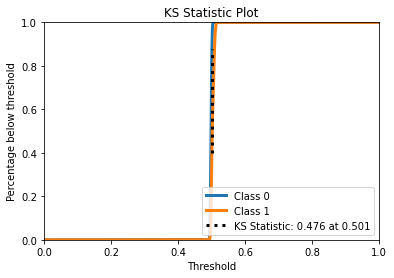

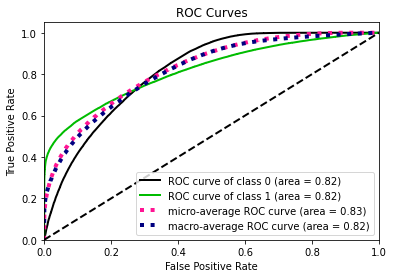

In [ ]:
print_metrics(y_valid, y_valid_pred_adaBoost, y_valid_proba_adaBoost)

### Modelo XGBoost

Descrição dos principais parâmetros utilizados:

- learning_rate
  - Possíveis valores: intervalo (0,0, inf)
  - default=0.1
  - A taxa de aprendizado reduz a contribuição de cada árvore por learning_rate. Há um trade-off entre learning_rate e n_estimators. 

- n_estimators
  - Os valores devem estar no intervalo [1, inf).
  - default=100
  - O número de estágios de reforço a serem executados. 
  - **O aumento de gradiente é bastante robusto ao over-fitting, portanto, um número grande geralmente resulta em melhor desempenho.

- max_depth
  - Os valores devem estar no intervalo [1, inf).
  - default=3
  - Ajuste este parâmetro para melhorar o desempenho; 
    - O melhor valor depende da interação das variáveis de entrada.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- learning_rate
  - default=0.1

- n_estimators
  - default=100

- max_depth
  - default=3

In [ ]:
clf_gb = xgb.XGBClassifier(random_state=27)

In [ ]:
%%time
clf_gb.fit(X_train, y_train)

CPU times: total: 8min 55s
Wall time: 51 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=27,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
y_pred_valid_gb_1st = clf_gb.predict(X_valid)

In [ ]:
y_pred_valid_proba_gb_1st = clf_gb.predict_proba(X_valid)

##### Análise de Desempenho

Accuracy: 0.7597
Recall: 0.6719
Precision: 0.8151
F1-Score: 0.7366
ROC AUC Score: 0.8426
Matriz de confusão no conjunto de teste:
[[54053  9721]
 [20924 42850]]


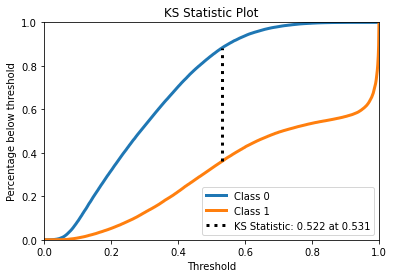

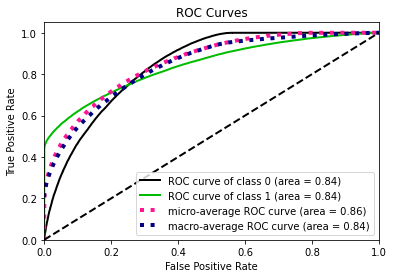

In [ ]:
print_metrics(y_valid, y_pred_valid_gb_1st, y_pred_valid_proba_gb_1st)

#### 2ª Configuração

Para a segunda configuração alteramos os seguintes parâmetros:

In [ ]:
def gradient_boosting(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.0951, step=0.005),
        'max_depth': trial.suggest_int('max_depth', 4, 100),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300, step=10)
    }

    gb_clf_trial = xgb.XGBClassifier(
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        n_estimators=params["n_estimators"],
        random_state=42
    )
    gb_clf_trial.fit(X_train, y_train)

    y_pred_proba = gb_clf_trial.predict_proba(X_valid)

    statistic = eval_ks_metric(y_valid, y_pred_proba)

    gc.collect()

    return statistic

In [ ]:
gb = optuna.create_study(direction="maximize")
gb.optimize(gradient_boosting, n_trials=n_trials)

[I 2022-10-16 02:46:31,554] A new study created in memory with name: no-name-6630c942-cfeb-41fb-9111-51e81415ba6a
[I 2022-10-16 02:59:49,987] Trial 0 finished with value: 0.5001881644557344 and parameters: {'learning_rate': 0.035100000000000006, 'max_depth': 61, 'n_estimators': 220}. Best is trial 0 with value: 0.5001881644557344.
[I 2022-10-16 03:08:44,157] Trial 1 finished with value: 0.49987455702951045 and parameters: {'learning_rate': 0.0601, 'max_depth': 64, 'n_estimators': 150}. Best is trial 0 with value: 0.5001881644557344.
[I 2022-10-16 03:21:25,396] Trial 2 finished with value: 0.5017248408442312 and parameters: {'learning_rate': 0.07010000000000001, 'max_depth': 66, 'n_estimators': 230}. Best is trial 2 with value: 0.5017248408442312.
[I 2022-10-16 03:31:30,806] Trial 3 finished with value: 0.49543701194844286 and parameters: {'learning_rate': 0.0301, 'max_depth': 61, 'n_estimators': 160}. Best is trial 2 with value: 0.5017248408442312.
[I 2022-10-16 03:47:45,790] Trial 4 f

##### Análise de Desempenho

In [ ]:
gb.best_params

{'learning_rate': 0.0551, 'max_depth': 10, 'n_estimators': 210}

Accuracy: 0.7632
Recall: 0.6666
Precision: 0.8263
F1-Score: 0.7379
ROC AUC Score: 0.8459
Matriz de confusão no conjunto de teste:
[[54838  8936]
 [21264 42510]]


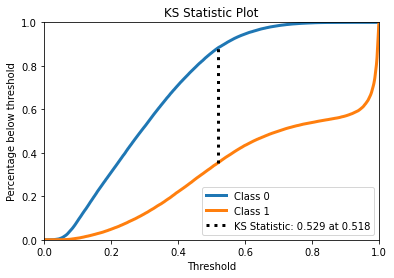

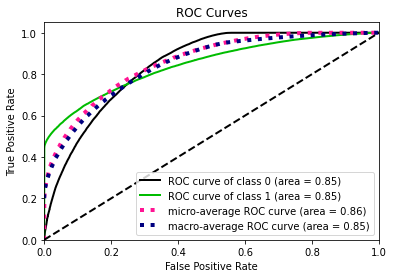

In [ ]:
gb_clf_trial = xgb.XGBClassifier(
    learning_rate=gb.best_params["learning_rate"],
    max_depth=gb.best_params["max_depth"],
    n_estimators=gb.best_params["n_estimators"],
    random_state=42
)

gb_clf_trial.fit(X_train, y_train)

y_pred_valid = gb_clf_trial.predict(X_valid)
y_pred_valid_proba = gb_clf_trial.predict_proba(X_valid)

print_metrics(y_valid, y_pred_valid, y_pred_valid_proba)

### Modelo VotingClassifier

Esse modelo utiliza diversos classificadores para treinar em cima do dataset e depois faz a votação para definir a classe final, baseado na maioria dos votos ou o argmax da soma das predições.

In [ ]:
# from sklearn.ensemble import VotingClassifier

Descrição dos principais parâmetros:

- estimators
  - Lista de tuplas (string, estimador) que definem os classificadores a serem usados no VotingClassifier.

- voting
  - Possíveis valores: {‘hard’, ‘soft’}
  - default=’hard’
  - Se ‘hard’, usa o voto duro. 
  - Se ‘soft’, usa o voto suave, onde os valores de classificação são baseados na probabilidade estimada.

Para esse caso vamos utilizar os melhores parâmetros dos estimadores que usamos anteriormente, com exceção do SVM.

In [ ]:
# mlp_ens_voting_clf = MLPClassifier()
# svc_ens_clf = SVC(probability=True)
# gb_ens_clf = xgb.XGBClassifier()
# rf_ens_clf = RandomForestClassifier()

# ens_clf = VotingClassifier([('mlp', mlp_ens_voting_clf), ('svc', svc_ens_clf), ('gb', gb_ens_clf), ('rf', rf_ens_clf)], voting='soft')

In [ ]:
# ens_clf.fit(X_train, y_train)

In [ ]:
#y_pred_valid_ens_clf = ens_clf.predict(X_valid)

In [ ]:
#y_pred_valid_proba_ens_clf = ens_clf.predict_proba(X_valid)

In [ ]:
#print_metrics(y_valid, y_pred_valid_ens_clf, y_pred_valid_proba_ens_clf)

## Comparação dos modelos

Vamos fazer agora a comparação dos melhores modelos de cada algoritmo aplicando no conjunto de teste.

#### MLP

In [ ]:
mlp_test = MLPClassifier(
    hidden_layer_sizes=(mlp_study.best_params['first_layer_neurons'], mlp_study.best_params['second_layer_neurons']),
    learning_rate_init=mlp_study.best_params['learning_rate_init'],
    activation=mlp_study.best_params['activation'],
    random_state=42
)

mlp_test.fit(X_train, y_train)

In [ ]:
y_pred_test_mlp = mlp_test.predict(X_test)
y_pred_test_proba_mlp = mlp_test.predict_proba(X_test)

#### Random Forest

In [ ]:
rnd_forest_test = RandomForestClassifier(
    n_estimators=rf_study.best_params["n_estimators"],
    max_depth=rf_study.best_params["max_depth"],
    max_leaf_nodes=rf_study.best_params["max_leaf_nodes"],
    random_state=0,
    n_jobs=-1
)

rnd_forest_test.fit(X_train, y_train)

In [ ]:
y_pred_test_rf = rnd_forest_test.predict(X_test)
y_pred_test_proba_rf = rnd_forest_test.predict_proba(X_test)

#### SVM

Como o SVM foi treinado anteriormente, usaremos apenas o conjunto de teste para fazer a predição.

In [ ]:
y_pred_test_svm = clf_svm.predict(X_test)
y_pred_test_proba_svm = clf_svm.predict_proba(X_test)

#### Ensemble de MLP

Igualmente ao SVM, o Ensemble de MLP foi treinado anteriormente, então usaremos apenas o conjunto de teste para fazer a predição.

In [ ]:
y_pred_test_ens_mlp = mlp_ens_clf.predict(X_test)
y_pred_test_proba_ens_mlp = mlp_ens_clf.predict_proba(X_test)

#### AdaBoost

O AdaBoost foi treinado anteriormente, então usaremos apenas o conjunto de teste para fazer a predição.

In [ ]:
y_pred_test_adaBoost = clf_adaBoost.predict(X_test)
y_pred_test_proba_adaBoost = clf_adaBoost.predict_proba(X_test)

NameError: name 'clf_adaBoost' is not defined

#### XGBoost

In [ ]:
gb_clf_test = xgb.XGBClassifier(
    learning_rate=gb.best_params["learning_rate"],
    max_depth=gb.best_params["max_depth"],
    n_estimators=gb.best_params["n_estimators"],
    random_state=42
)

gb_clf_test.fit(X_train, y_train)

In [ ]:
y_pred_test_gb = gb_clf_test.predict(X_test)
y_pred_test_proba_gb = gb_clf_test.predict_proba(X_test)

#### VotingClassifier

O VotingClassifier foi treinado anteriormente, então usaremos apenas o conjunto de teste para fazer a predição.

In [ ]:
# y_pred_test_ens_clf = ens_clf.predict(X_test)
# y_pred_test_proba_ens_clf = ens_clf.predict_proba(X_test)

### Exibição dos resultados

In [ ]:
print("------MLP------")
print_metrics(y_test, y_pred_test_mlp, y_pred_test_proba_mlp)

print("------SVM------")
print_metrics(y_test, y_pred_test_svm, y_pred_test_proba_svm)

print("------Random Forest------")
print_metrics(y_test, y_pred_test_rf, y_pred_test_proba_rf)

print("------Ensemble MLP------")
print_metrics(y_test, y_pred_test_ens_mlp, y_pred_test_proba_ens_mlp)

print("------Adaboost------")
print_metrics(y_test, y_pred_test_adaBoost, y_pred_test_proba_adaBoost)

print("------Gradient Boosting------")
print_metrics(y_test, y_pred_test_gb, y_pred_test_proba_gb)

------MLP------


NameError: name 'print_metrics' is not defined

# Anexos

Descrição dos parâmetros:

- n_estimators
  - O número de árvores na floresta.


In [ ]:
%pip install --user tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- n_

In [ ]:
def create_sklearn_compatible_model():
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
clf_mlp = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100,
                          verbose=0)


C:\Users\jonat\AppData\Local\Temp\ipykernel_20704\3075366852.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_mlp = KerasClassifier(build_fn=create_sklearn_compatible_model,


In [ ]:
%%time
clf_mlp.fit(X_train, y_train)

CPU times: total: 2min 18s
Wall time: 4min 59s


In [ ]:
y_pred_mlp = clf_mlp.predict(X_valid)

3986/3986 [==============================] - 3s 655us/step


In [ ]:
y_proba_mlp = clf_mlp.predict_proba(X_valid)

3986/3986 [==============================] - 2s 614us/step


##### Análise de Desempenho

Métricas da 1ª configuração do Random Forest:

Accuracy: 0.7325
Recall: 0.6667
Precision: 0.7678
F1-Score: 0.7136
ROC AUC Score: 0.8159
Matriz de confusão no conjunto de teste:
[[50914 12860]
 [21259 42515]]


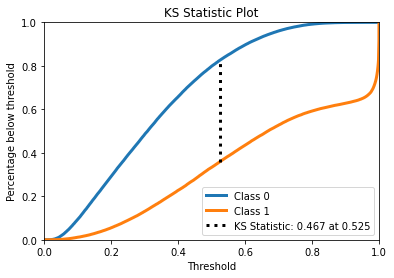

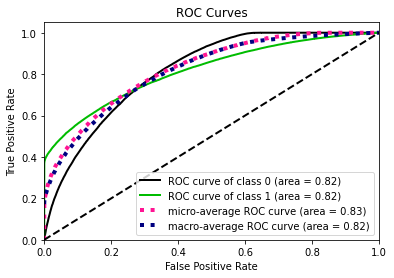

In [ ]:
print('Métricas da 1ª configuração do Random Forest:\n')
print_metrics(y_valid, y_pred_mlp, y_proba_mlp)

#### 2ª Configuração

Para a segunda configuração alteramos os seguintes parâmetros:

#### Random Forest usando K-fold Cross Validation

Não teremos mais isso

In [ ]:
from sklearn.model_selection import KFold

scores = []
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
kfold = KFold(n_splits=3, shuffle=True)

# for train_index, test_index in cv.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index, "LEN:", X_train.loc[255096:255097])
#     X_train2, X_test2, y_train2, y_test2 = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
#     clf_rf.fit(X_train2, y_train2)
#     scores.append(clf_rf.score(X_test2, y_test2))

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf_rf, X_train, y_train, cv=kfold, scoring='accuracy')

array([0.76110451, 0.75957569, 0.76192492])